In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.plotting import Plot
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, average_precision_score, precision_recall_curve

#### Load results df

In [2]:
base_path = '/home/zzaiman/local/CS334FinalProject/final_repo'
config = json.load(open(os.path.join(base_path, 'analysis/config.json'), 'r'))

In [3]:
labels = 'Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices'.split(',')

In [4]:
cyclical_results = config['CYCLICAL_RESULTS_PATH']
result_cyclical = pd.read_csv(os.path.join(cyclical_results, 'results.csv'))
admissions = pd.read_csv(config['ADMISSIONS_PATH'])
metadata = pd.read_csv(config['META_PATH'])
icu = pd.read_csv(config['ICU_PATH'])
patients = pd.read_csv(config['DEMO_PATH'])

In [5]:
#IT IS DEFINITELY FINE BEFORE THIS PART
result_cyclical.columns

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'dicom_id', 'split', 'PerformedProcedureStepDescription',
       'ViewPosition', 'Rows', 'Columns', 'StudyDate', 'StudyTime',
       'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'path',
       'pred_Atelectasis', 'pred_Cardiomegaly', 'pred_Consolidation',
       'pred_Edema', 'pred_Enlarged Cardiomediastinum', 'pred_Fracture',
       'pred_Lung Lesion', 'pred_Lung Opacity', 'pred_No Finding',
       'pred_Pleural Effusion', 'pred_Pleural Other', 'pred_Pneumonia',
       'pred_Pneumothorax', 'pred_Support Devices'],
      dtype='object')

In [6]:
metadata['StudyDate'] = pd.to_datetime(metadata['StudyDate'], format='%Y%m%d')
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])

# Filter metadata for the correct admission when the xray was taken.
meta_admissions = metadata.merge(admissions, on='subject_id', how='left')
meta_admissions = meta_admissions[(meta_admissions['StudyDate'] >= meta_admissions['admittime']) 
                                        & (meta_admissions['StudyDate'] >= meta_admissions['dischtime'])].reset_index(drop=True)
meta_admissions = meta_admissions.drop_duplicates(subset=['study_id'])
col_list = [col for col in meta_admissions.columns if col not in result_cyclical]
col_list.append('study_id')

meta_admissions = meta_admissions[col_list]

orig_shape = result_cyclical.shape[0]
result_cyclical = result_cyclical.merge(meta_admissions, on='study_id', how='left')
assert result_cyclical.shape[0] == orig_shape

#### Generate df for ICU patients

In [7]:
icu['intime'] = pd.to_datetime(icu['intime'])
icu['outtime'] = pd.to_datetime(icu['outtime'])

# Merge with ICU and filter for all study dates in an ICU stay for the same patient.
metadata_icu = metadata.merge(icu, on='subject_id')
metadata_icu = metadata_icu[(metadata_icu['StudyDate'] >= metadata_icu['intime']) & (metadata_icu['StudyDate'] <= metadata_icu['outtime'])].reset_index(drop=True)

# Drop duplicates on study ID since all patients in this df are in the ICU.
metadata_icu = metadata_icu.drop_duplicates(subset=['study_id'])
metadata_icu.shape

metadata_icu['study_in_icu'] = 1
metadata_icu_studies = metadata_icu[['study_id', 'study_in_icu']]
results_icu = result_cyclical.merge(metadata_icu_studies, on='study_id', how='left')
results_icu['study_in_icu'].fillna(0, inplace=True)
results_icu['study_in_icu'].value_counts()

0.0    2495
1.0     908
Name: study_in_icu, dtype: int64

In [8]:
result_cyclical['study_in_icu'] = results_icu['study_in_icu'].astype(str)

#### Generate race buckets

In [9]:
def label_races(row):
        if row['race'] in ['BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND']:
            return 'black'
        if row['race'] in ['WHITE', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - RUSSIAN', 'PORTUGUESE']:
            return 'white'
        if row['race'] in ['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 'SOUTH AMERICAN']:
            return 'hispanic/latino'
        if row['race'] in ['ASIAN - ASIAN INDIAN', 'ASIAN - KOREAN', 'ASIAN - CHINESE', 'ASIAN', 'ASIAN - SOUTH EAST ASIAN']:
            return 'asian'
        return 'other'

result_cyclical['race_bucket'] = result_cyclical.apply(lambda row: label_races(row), axis=1)

#### Generate age buckets

In [10]:
orig_shape = result_cyclical.shape[0]
result_cyclical = result_cyclical.merge(patients, on='subject_id')
# Make sure there was a one to one merge. 
assert result_cyclical.shape[0] == orig_shape

In [11]:
def age_groups(x):
        if x['anchor_age'] < 30:
            return '20-29'
        if x['anchor_age'] < 40:
            return '30-39'
        if x['anchor_age'] < 50:
            return '40-49'
        if x['anchor_age'] < 60:
            return '50-59'
        if x['anchor_age'] < 70:
            return '60-69'
        if x['anchor_age'] < 80:
            return '70-79'
        if x['anchor_age'] < 90:
            return '80-89'
        else: return '90+'

result_cyclical['age_cohort'] = result_cyclical.apply(lambda row: age_groups(row), axis=1)

#### Calculate TPR Disparity

In [12]:
pred_labels = ['pred_' + label for label in labels]
rounded_results = result_cyclical.copy()
for lab in pred_labels:
    rounded_results[lab] = rounded_results[lab].apply(round)

In [13]:
g = Group()
b = Bias()

attr_cols = ['insurance', 'age_cohort', 'gender', 'race_bucket', 'study_in_icu']
label_tpr_disparity = []

for label in labels:
    keep_cols = ['subject_id', 'study_id', 'race', 'insurance',  'gender', 'age_cohort', 'race_bucket', 'study_in_icu']
    keep_cols.append(label)
    pred_label = 'pred_' + label
    keep_cols.append(pred_label)
    label_df = rounded_results.copy().filter(keep_cols, axis=1).rename(
        columns={
            label: 'label_value', 
            pred_label: 'score'
            })
  
    xtab, _ = g.get_crosstabs(label_df, attr_cols=attr_cols)
    bdf = b.get_disparity_major_group(xtab, original_df=label_df,  alpha=0.05, mask_significance=True)
    bdf['label'] = label
    calculated_disparities = b.list_disparities(bdf)
    disparity_significance = b.list_significance(bdf)
    label_tpr_disparity.append((bdf, calculated_disparities, disparity_significance))

get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()
get_disparity_major_group()


In [14]:
frames = [label_tpr_disparity[i][0].filter(['model_id', 'score_threshold', 'k', 'attribute_name', 'attribute_value', 'tpr_disparity', 'tpr_ref_group_value', 'label'], axis=1) for i, _ in enumerate(label_tpr_disparity)]

concat_label_tpr_disparity = pd.concat(frames, ignore_index=True)
concat_label_tpr_disparity

,model_id,score_threshold,k,attribute_name,attribute_value,tpr_disparity,tpr_ref_group_value,label
0,0,binary 0/1,1610,insurance,Medicaid,0.931060,Medicare,Atelectasis
1,0,binary 0/1,1610,insurance,Medicare,1.000000,Medicare,Atelectasis
2,0,binary 0/1,1610,insurance,Other,0.876141,Medicare,Atelectasis
3,0,binary 0/1,1610,age_cohort,20-29,NaN,60-69,Atelectasis
4,0,binary 0/1,1610,age_cohort,30-39,0.930047,60-69,Atelectasis
...,...,...,...,...,...,...,...,...
275,0,binary 0/1,1980,race_bucket,hispanic/latino,0.982375,white,Support Devices
276,0,binary 0/1,1980,race_bucket,other,1.109526,white,Support Devices
277,0,binary 0/1,1980,race_bucket,white,1.000000,white,Support Devices
278,0,binary 0/1,1980,study_in_icu,0.0,1.000000,0.0,Support Devices


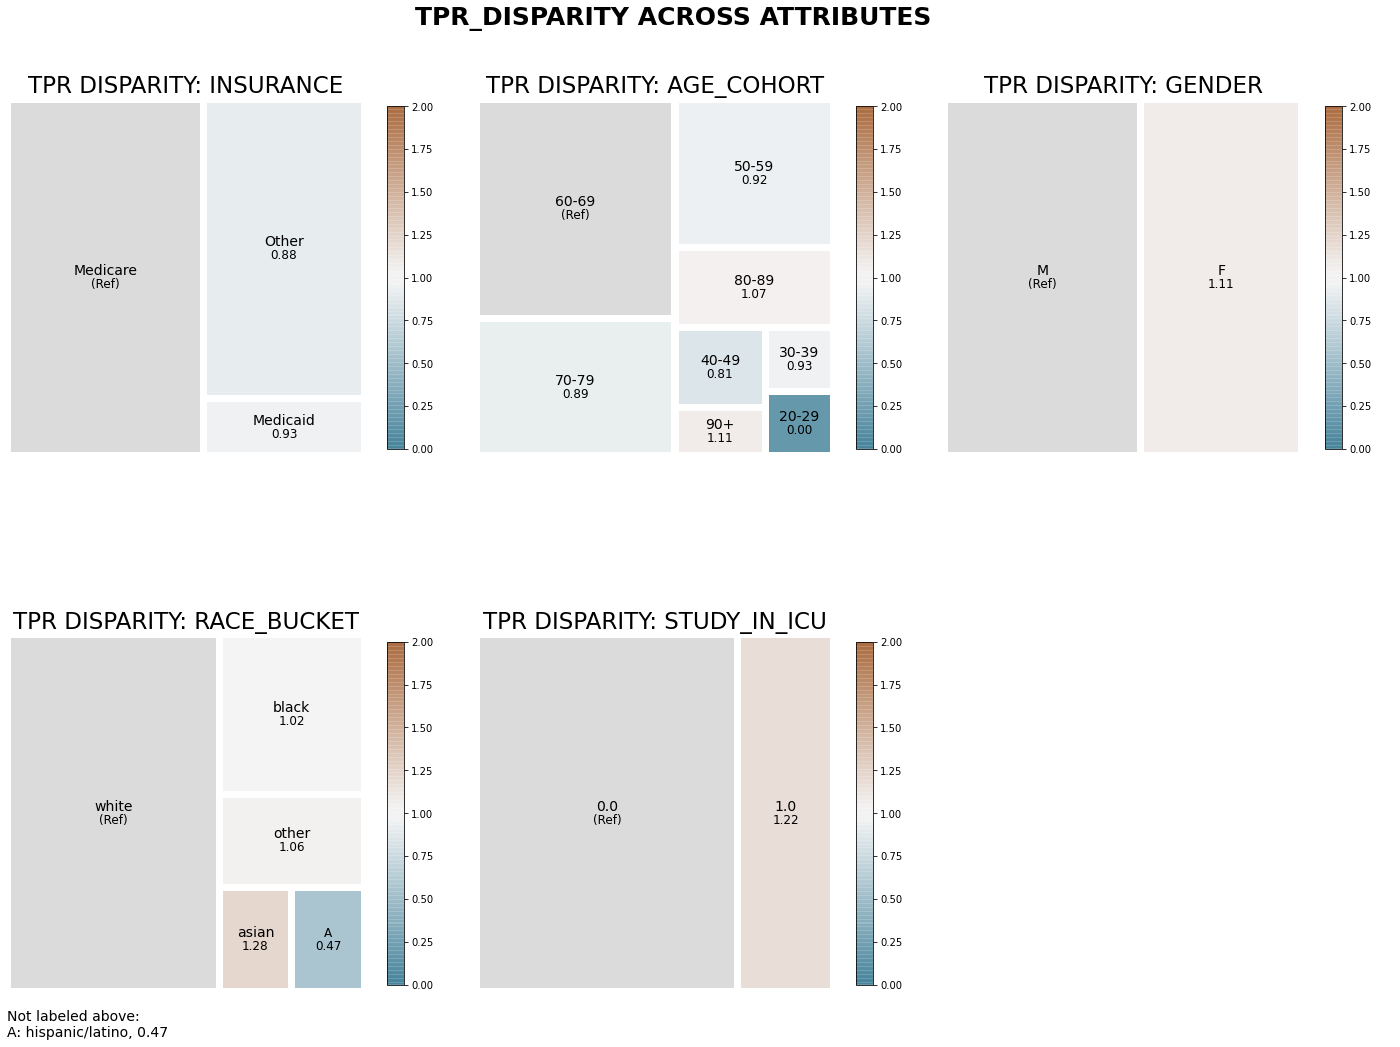

In [21]:
fg = aqp.plot_disparity_all(label_tpr_disparity[0][0], metrics=['tpr_disparity'], show_figure=False)

Atelectasis

Cardiomegaly

Consolidation

Edema

Enlarged Cardiomediastinum

Fracture

Lung Lesion

Lung Opacity

No Finding

Pleural Effusion

Pleural Other

Pneumonia

Pneumothorax

Support Devices



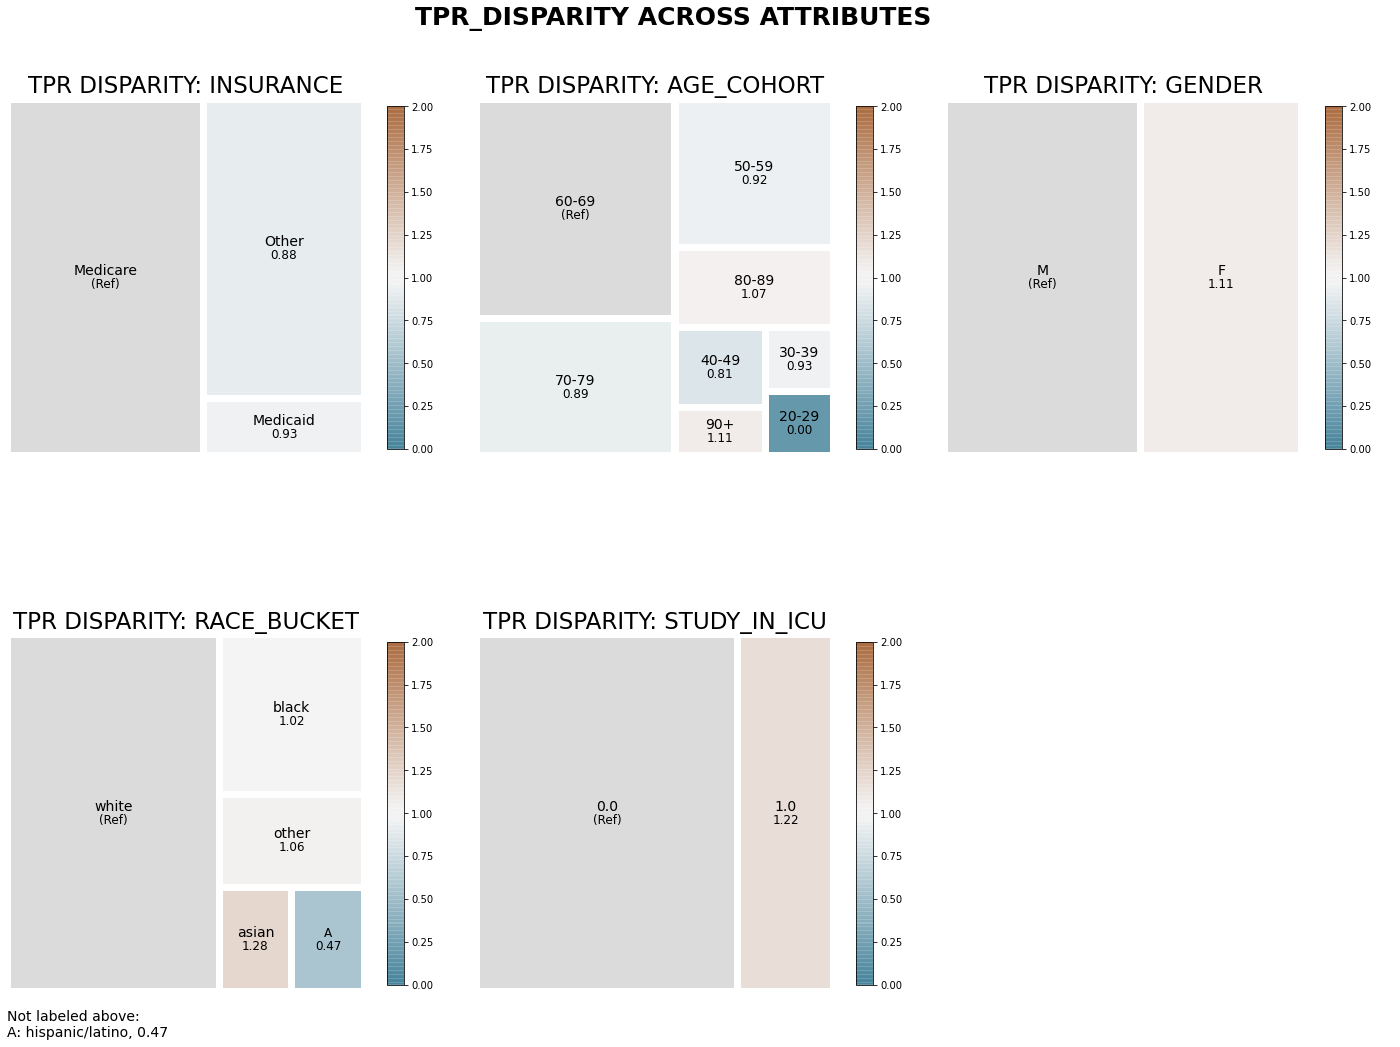

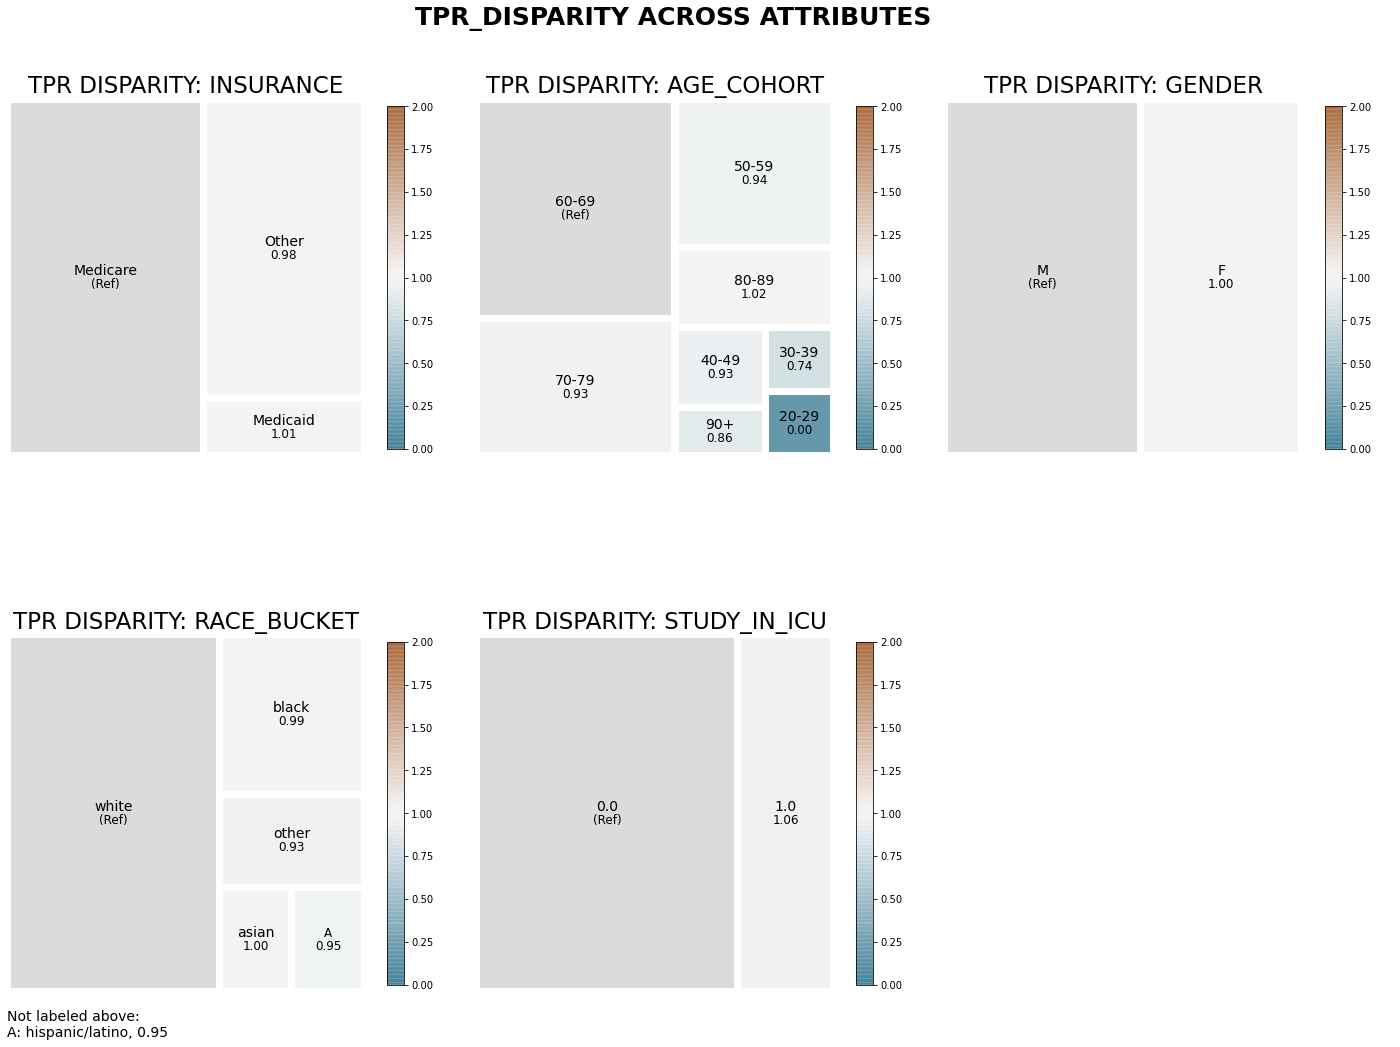

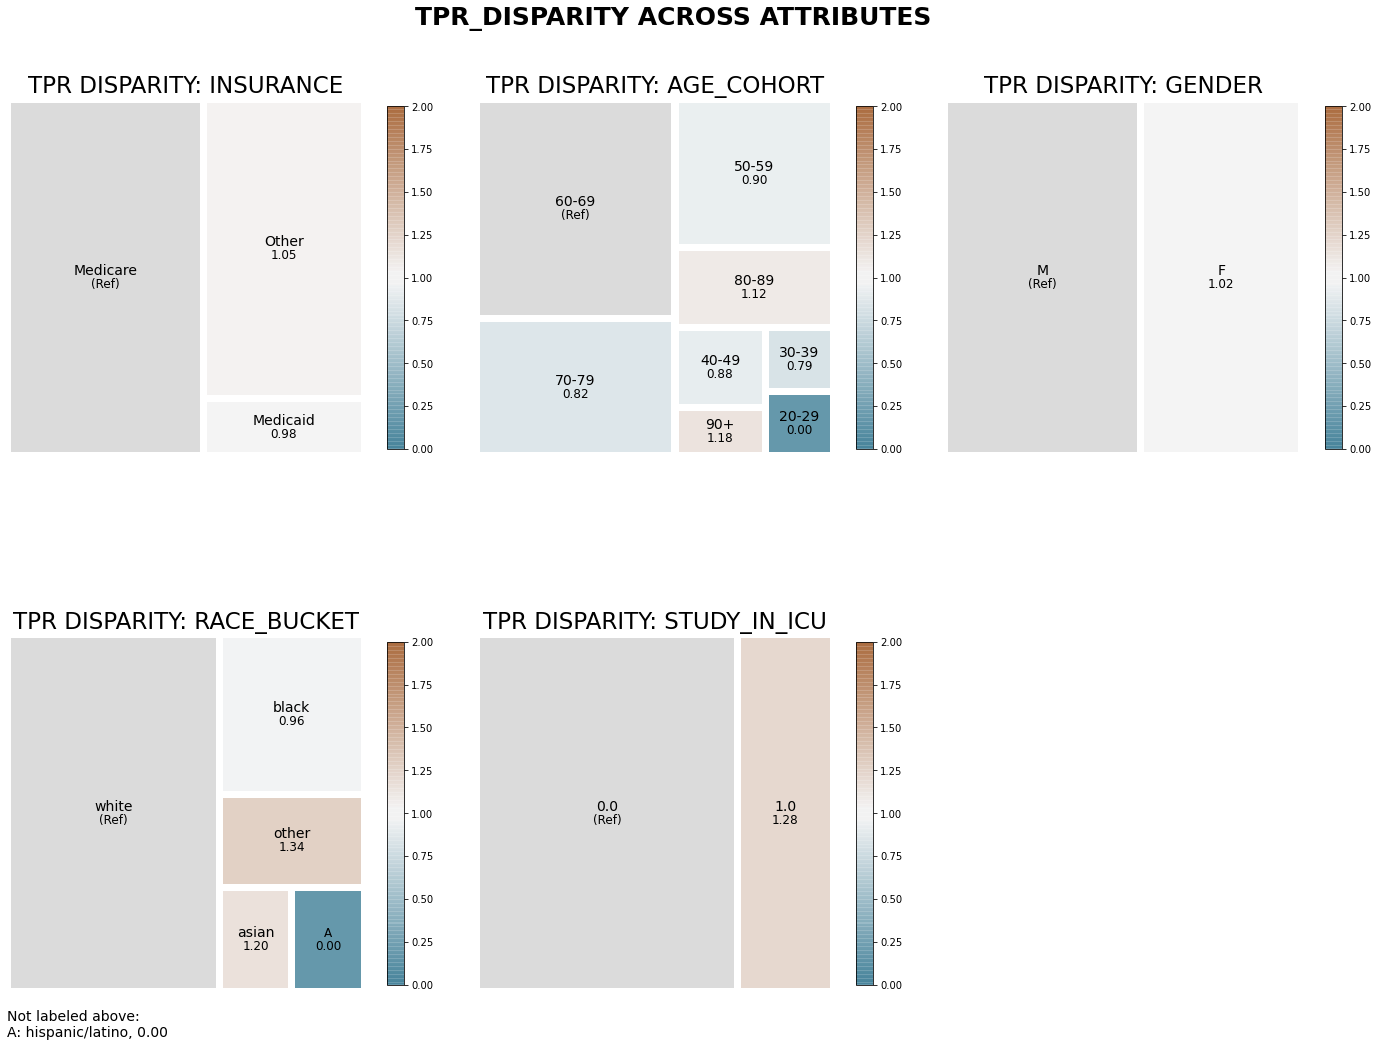

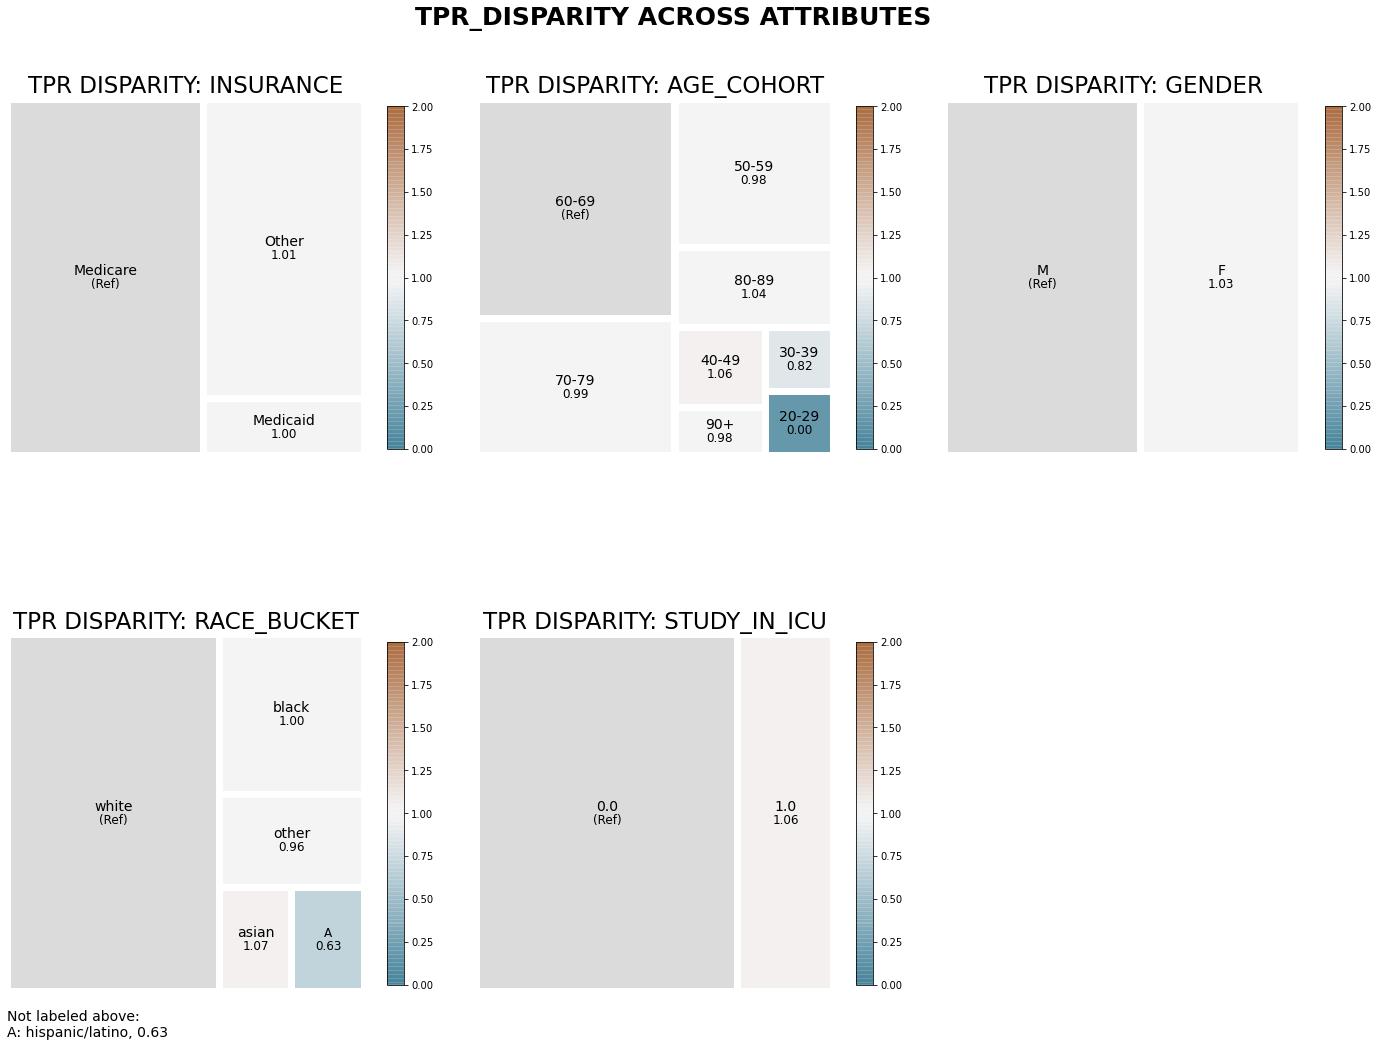

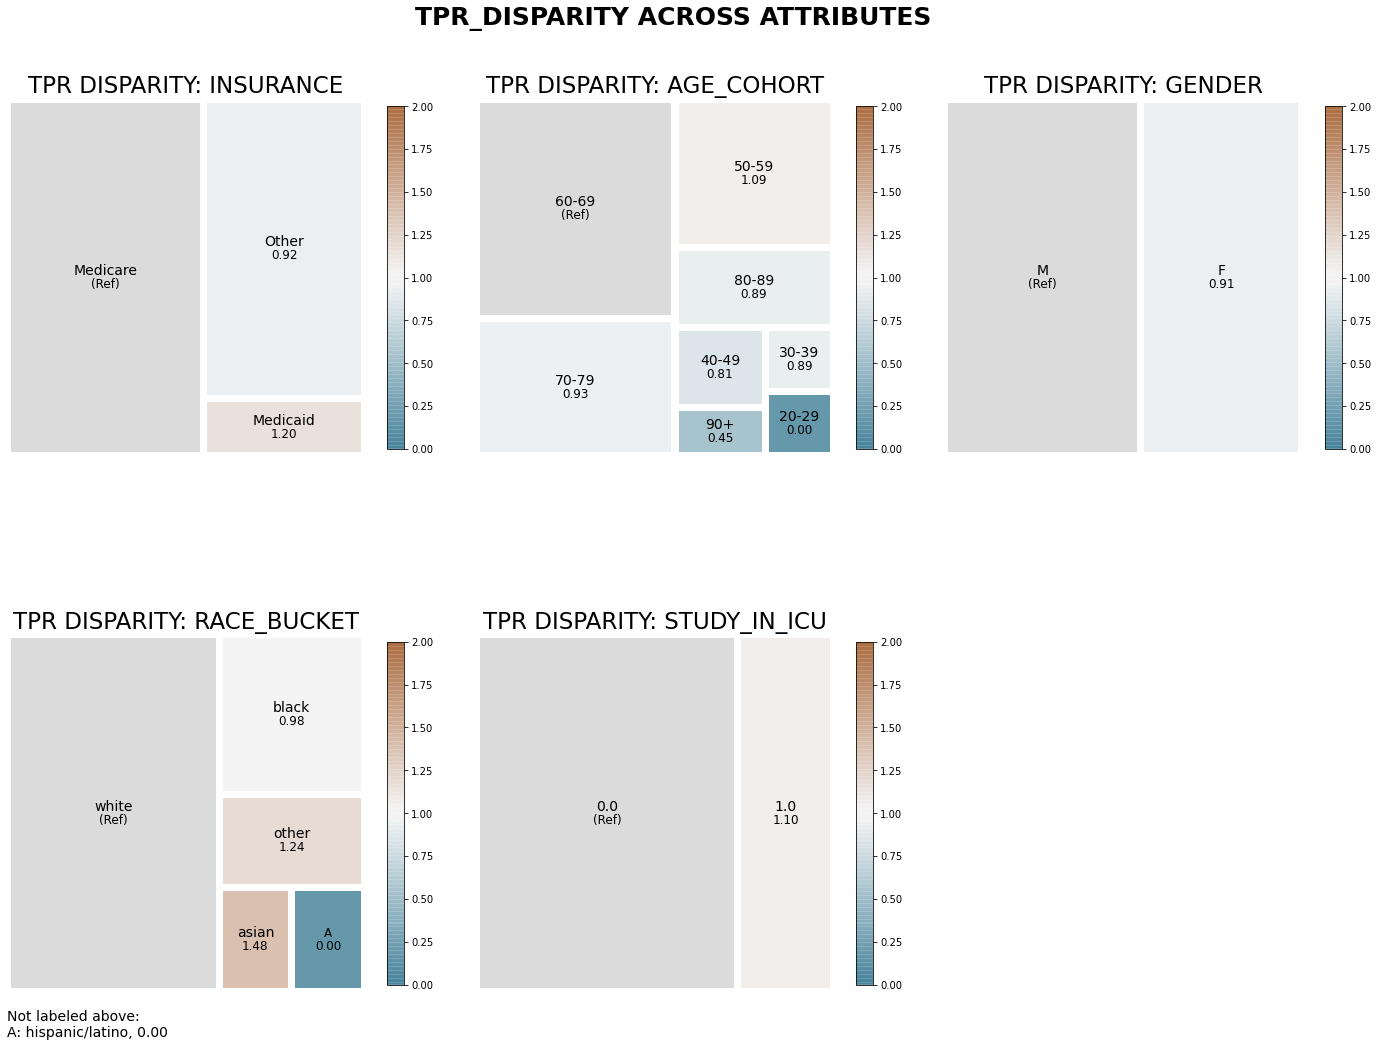

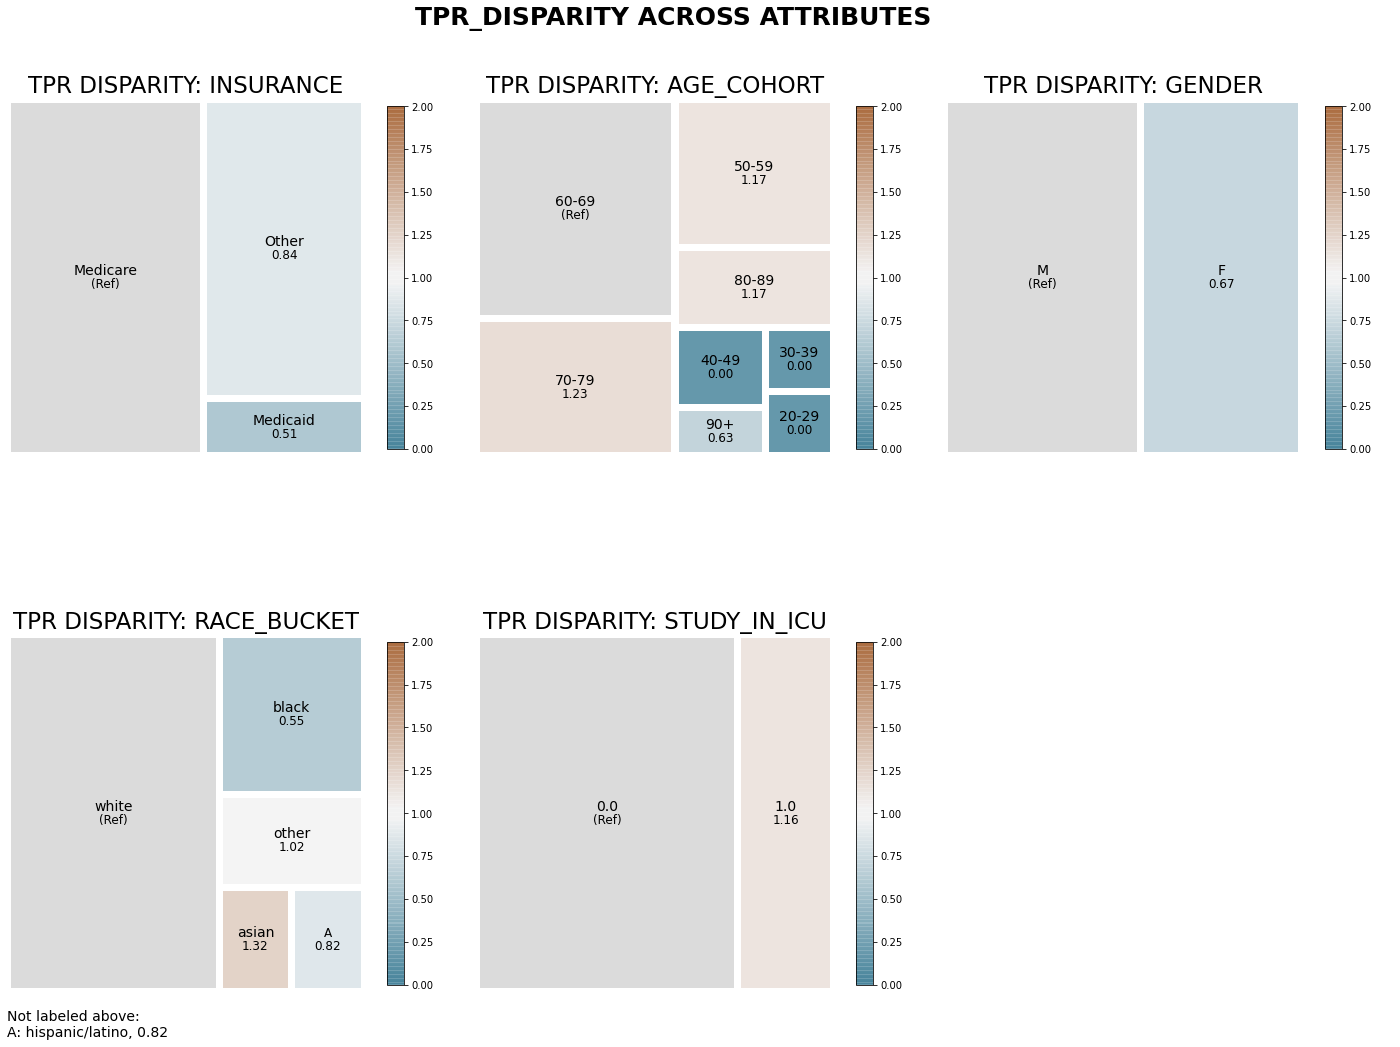

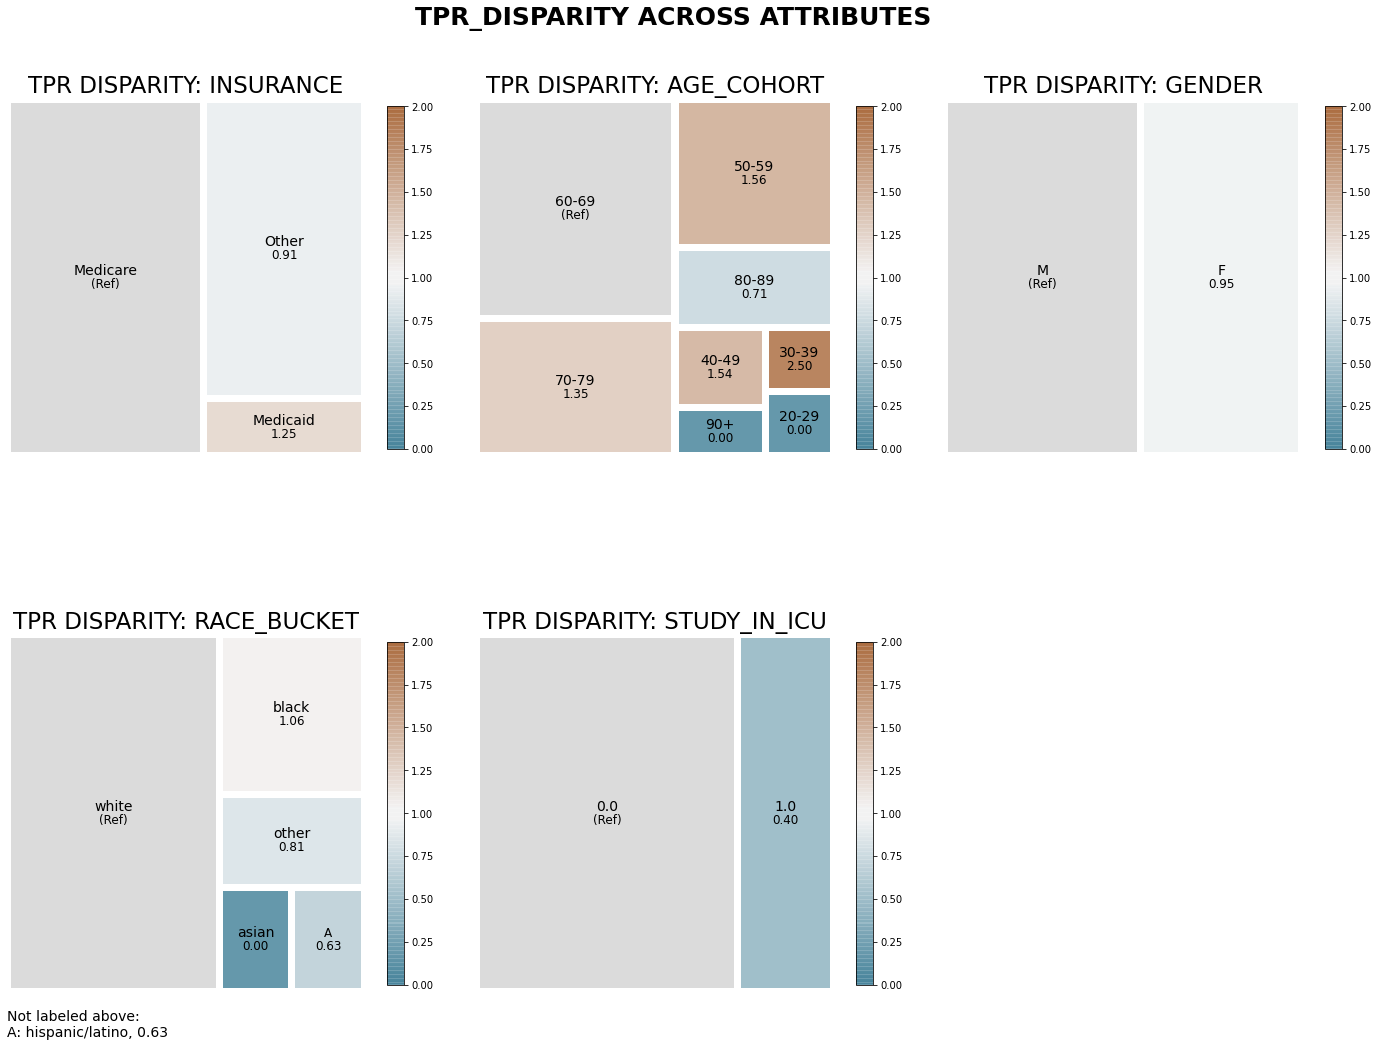

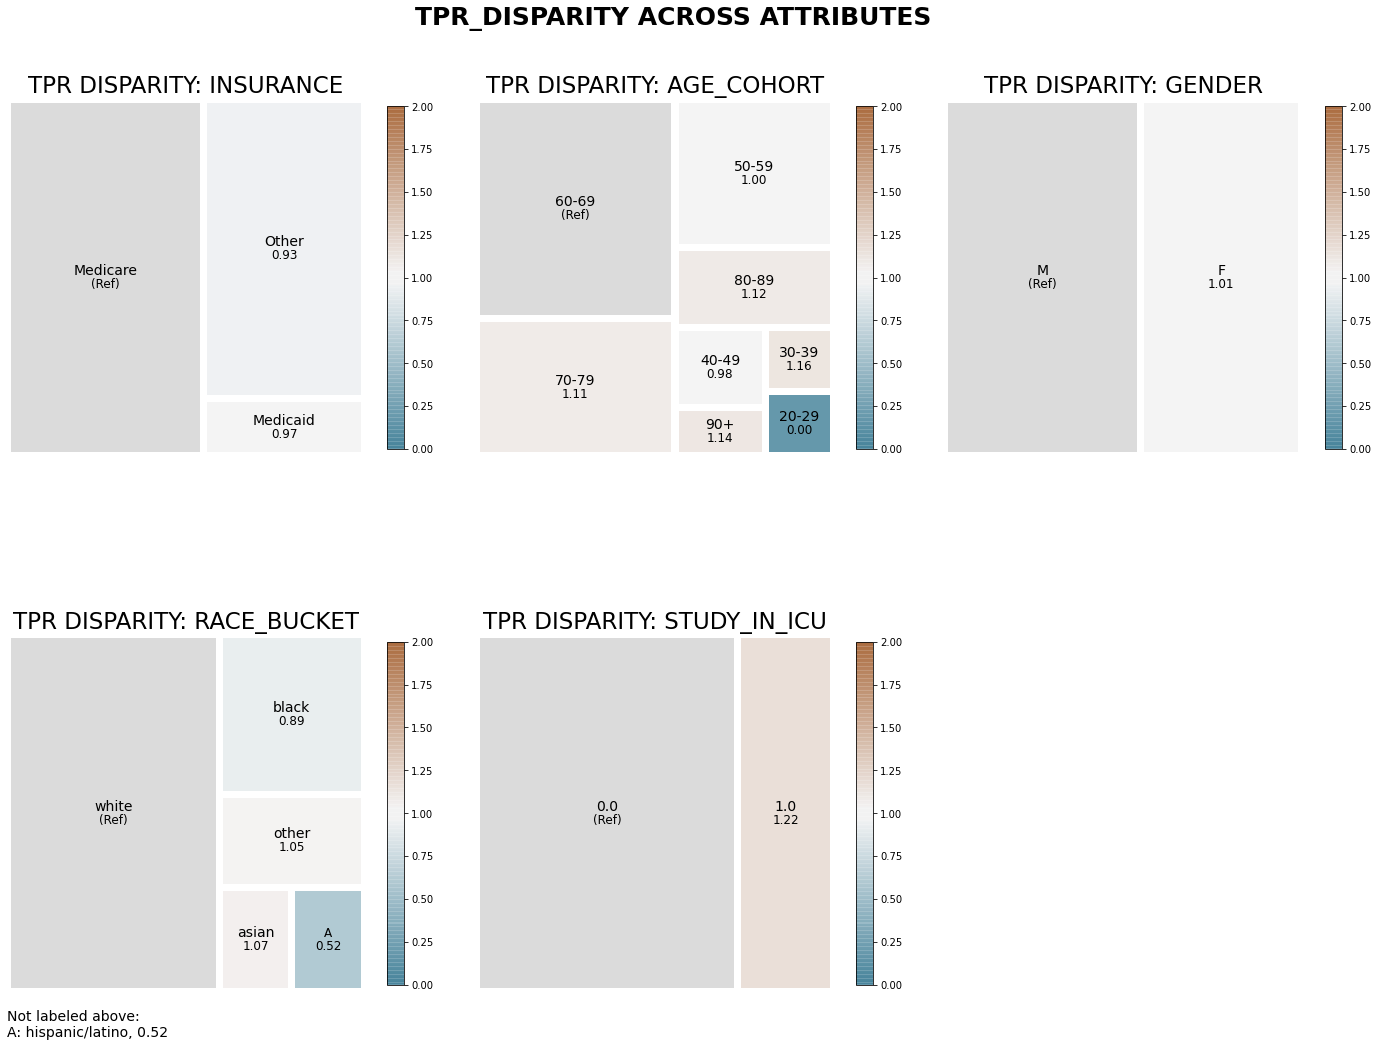

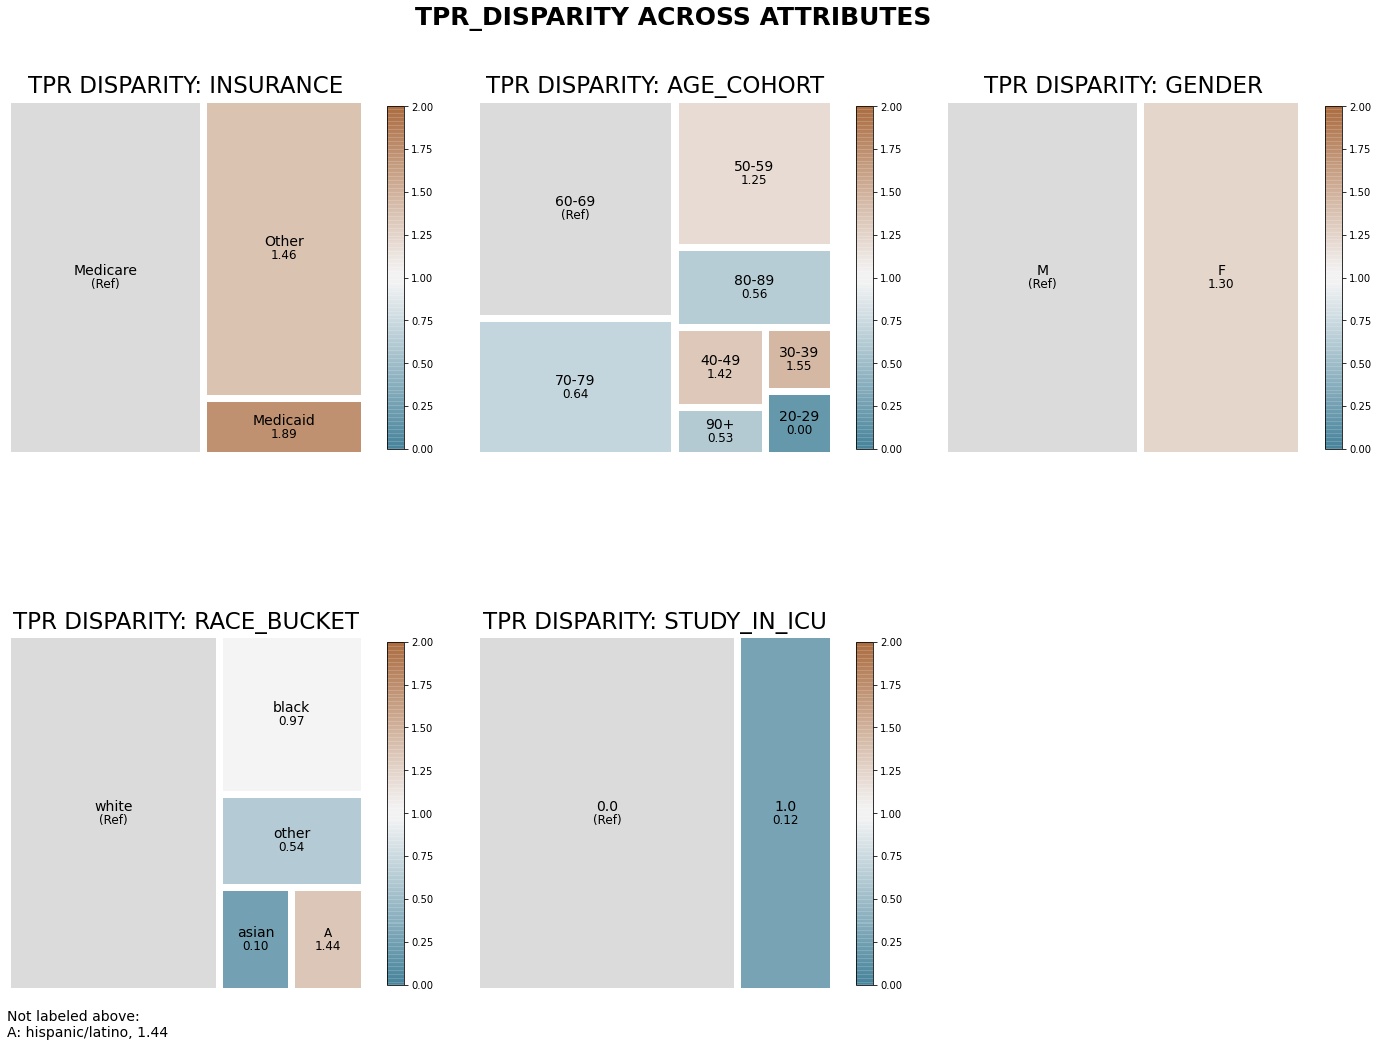

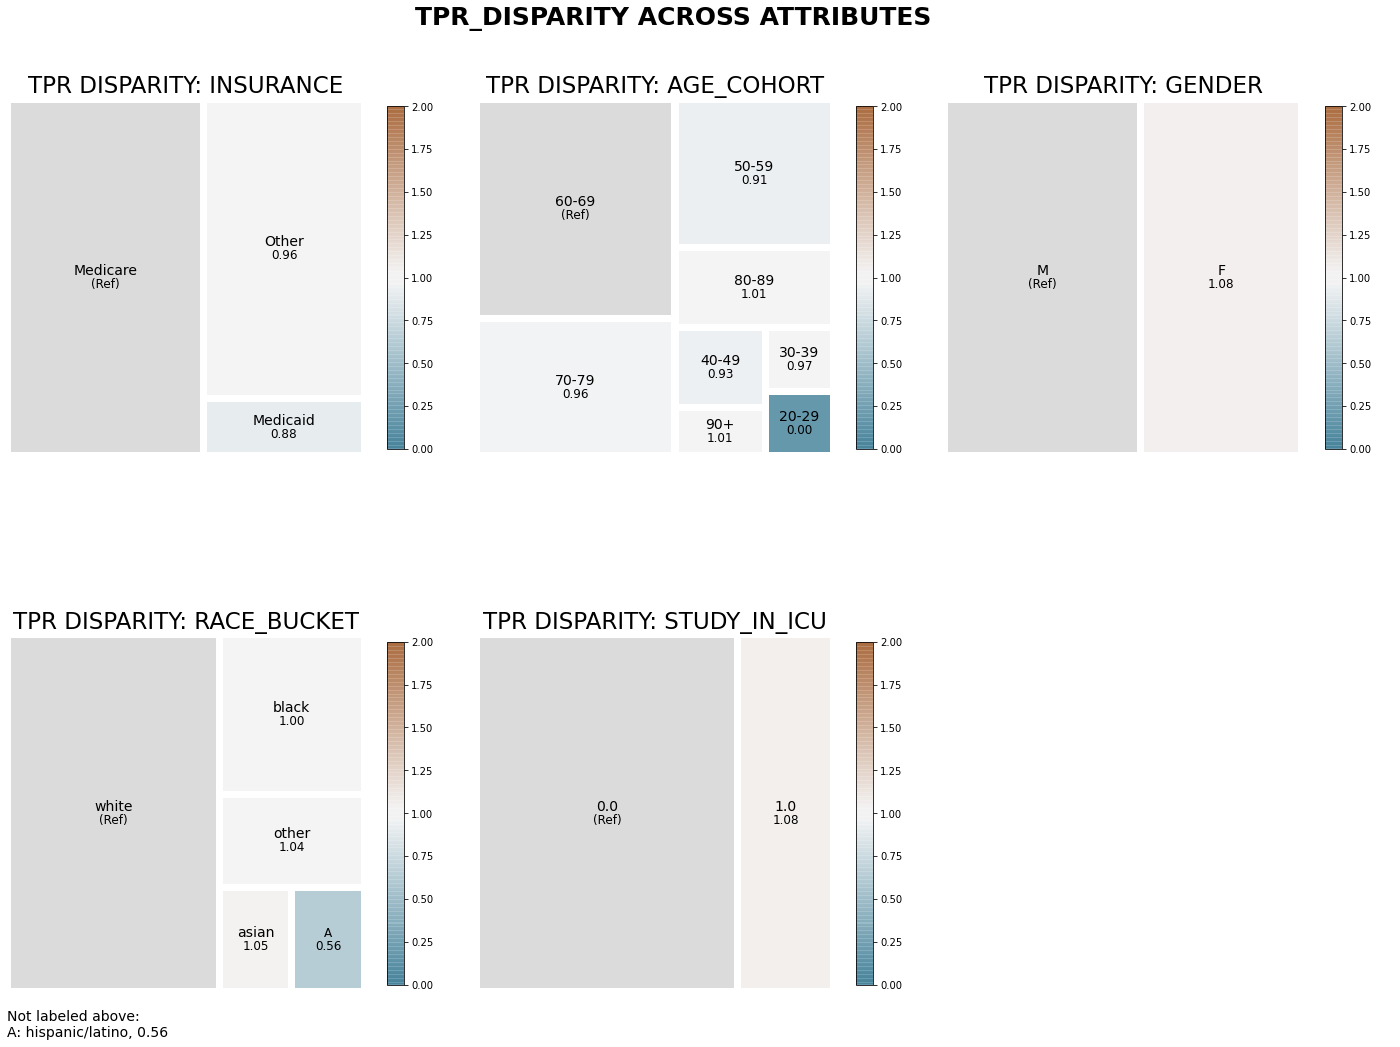

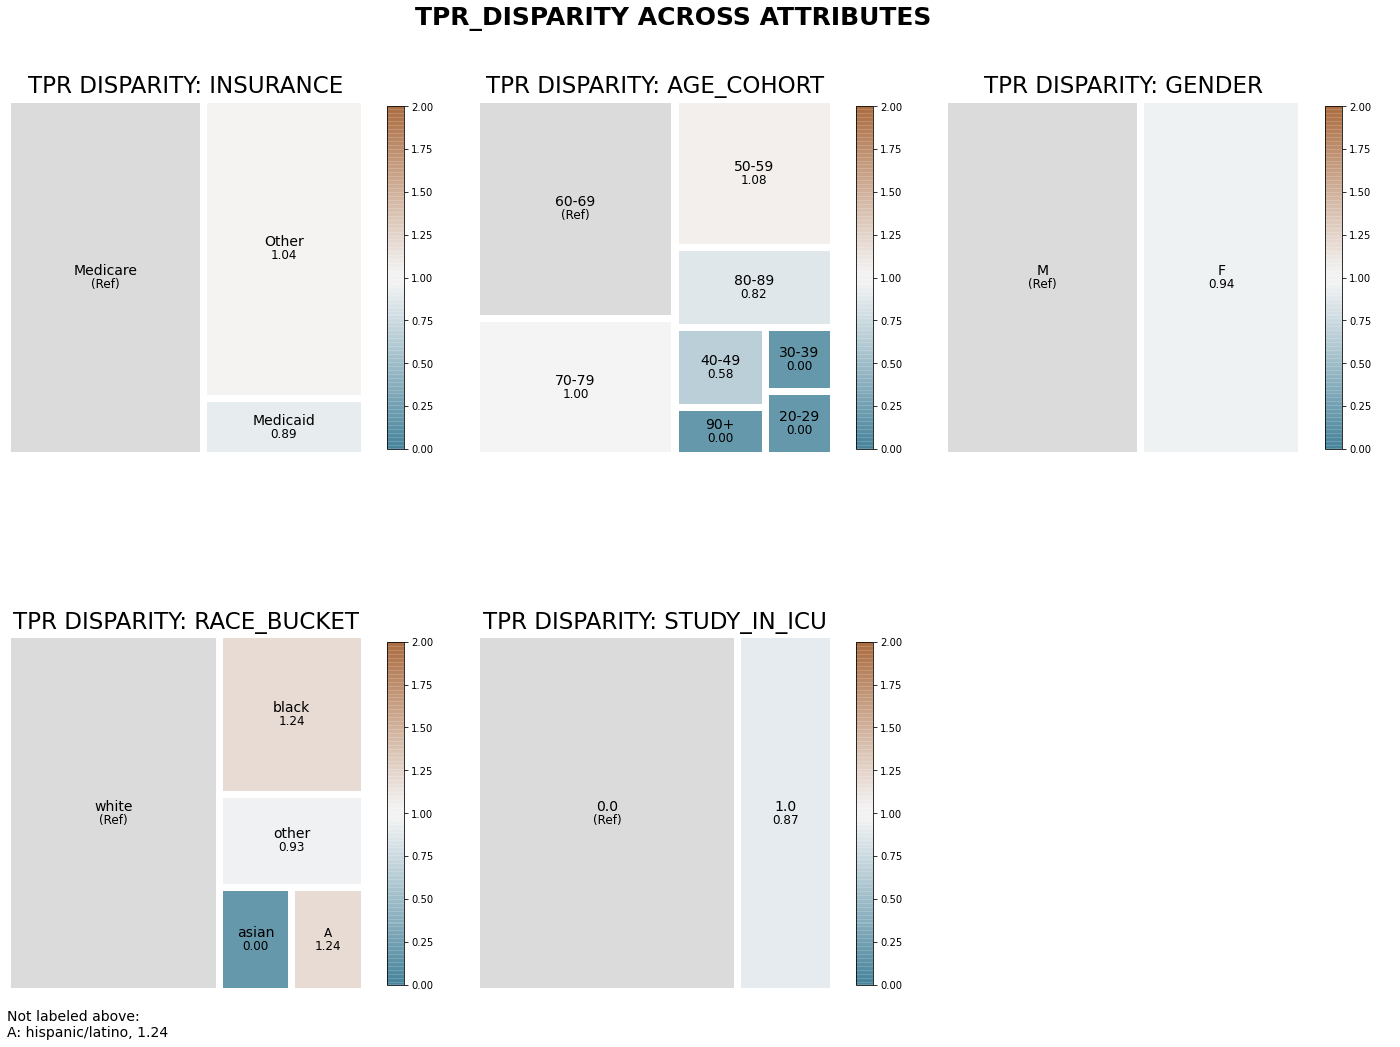

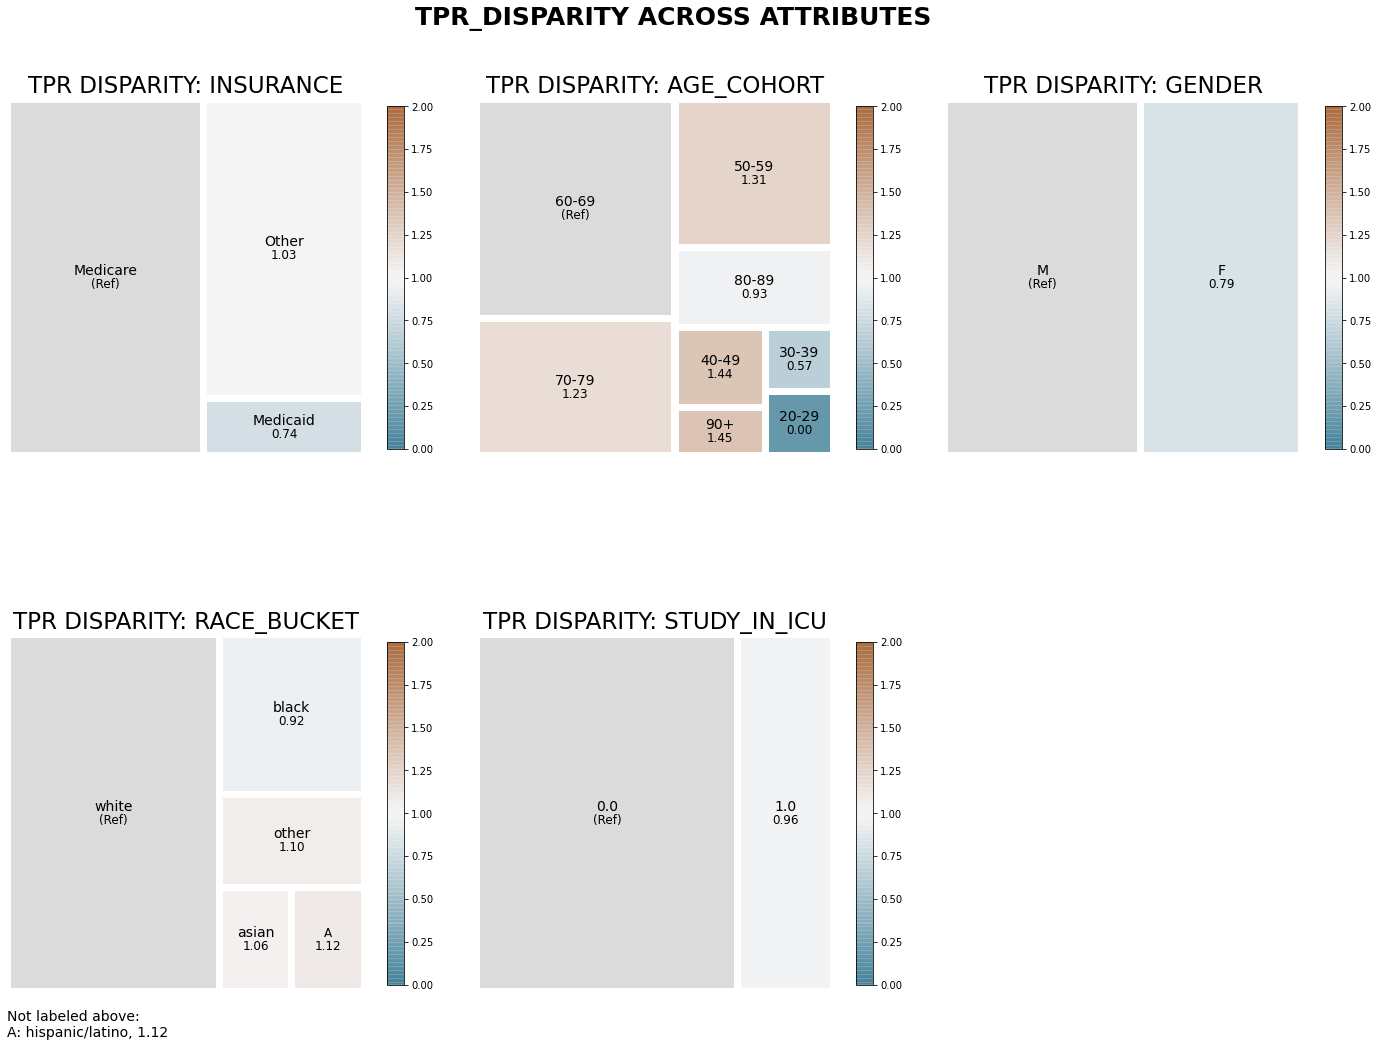

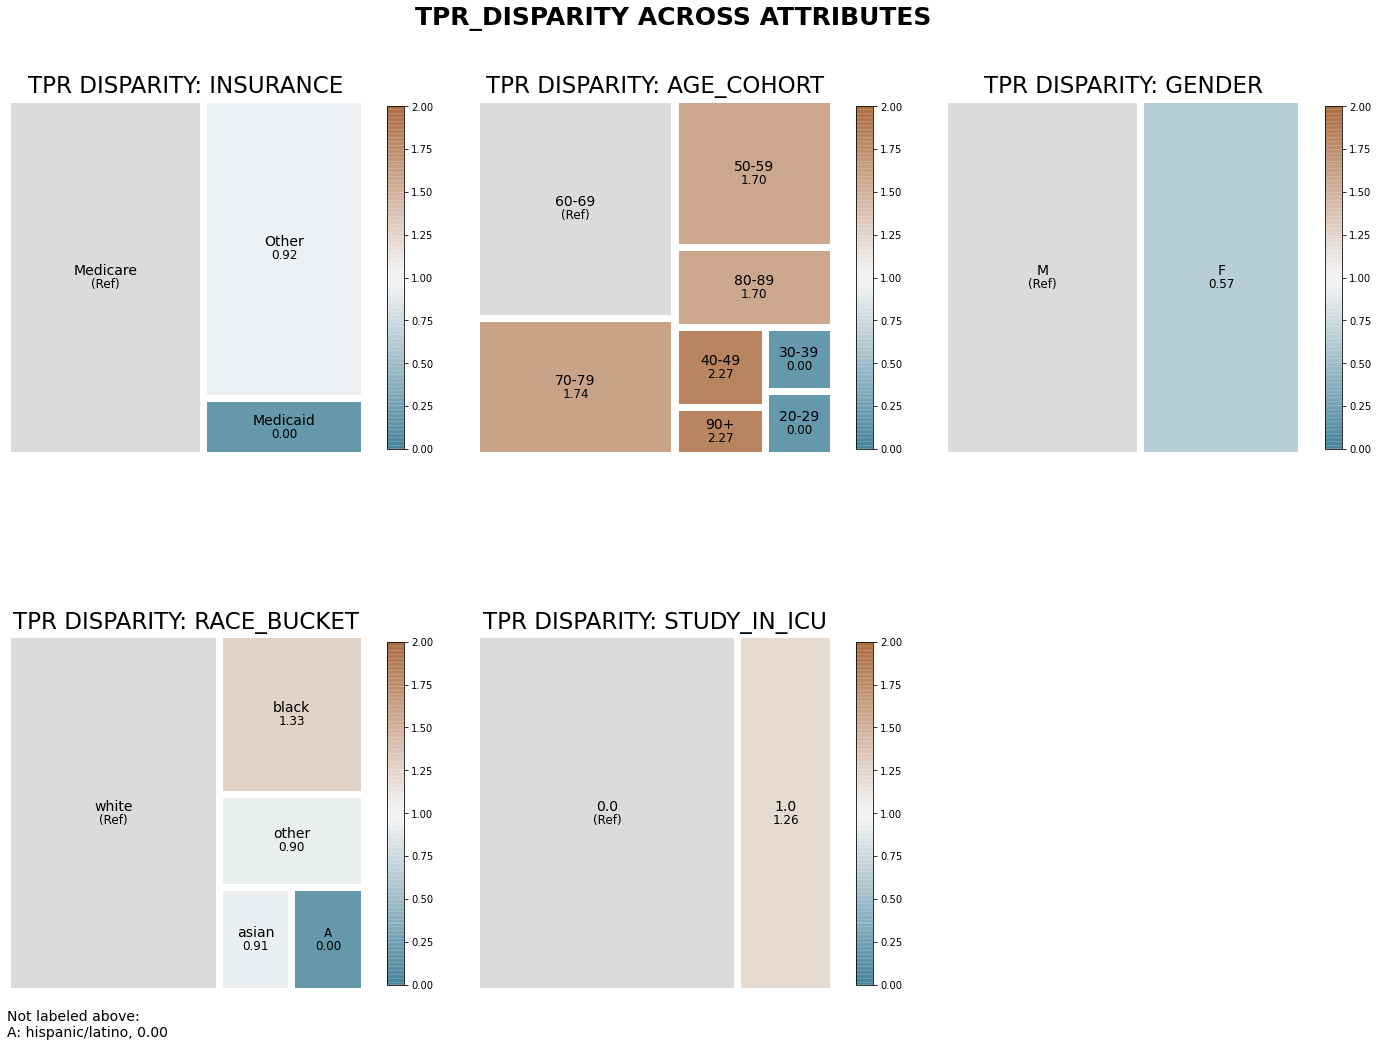

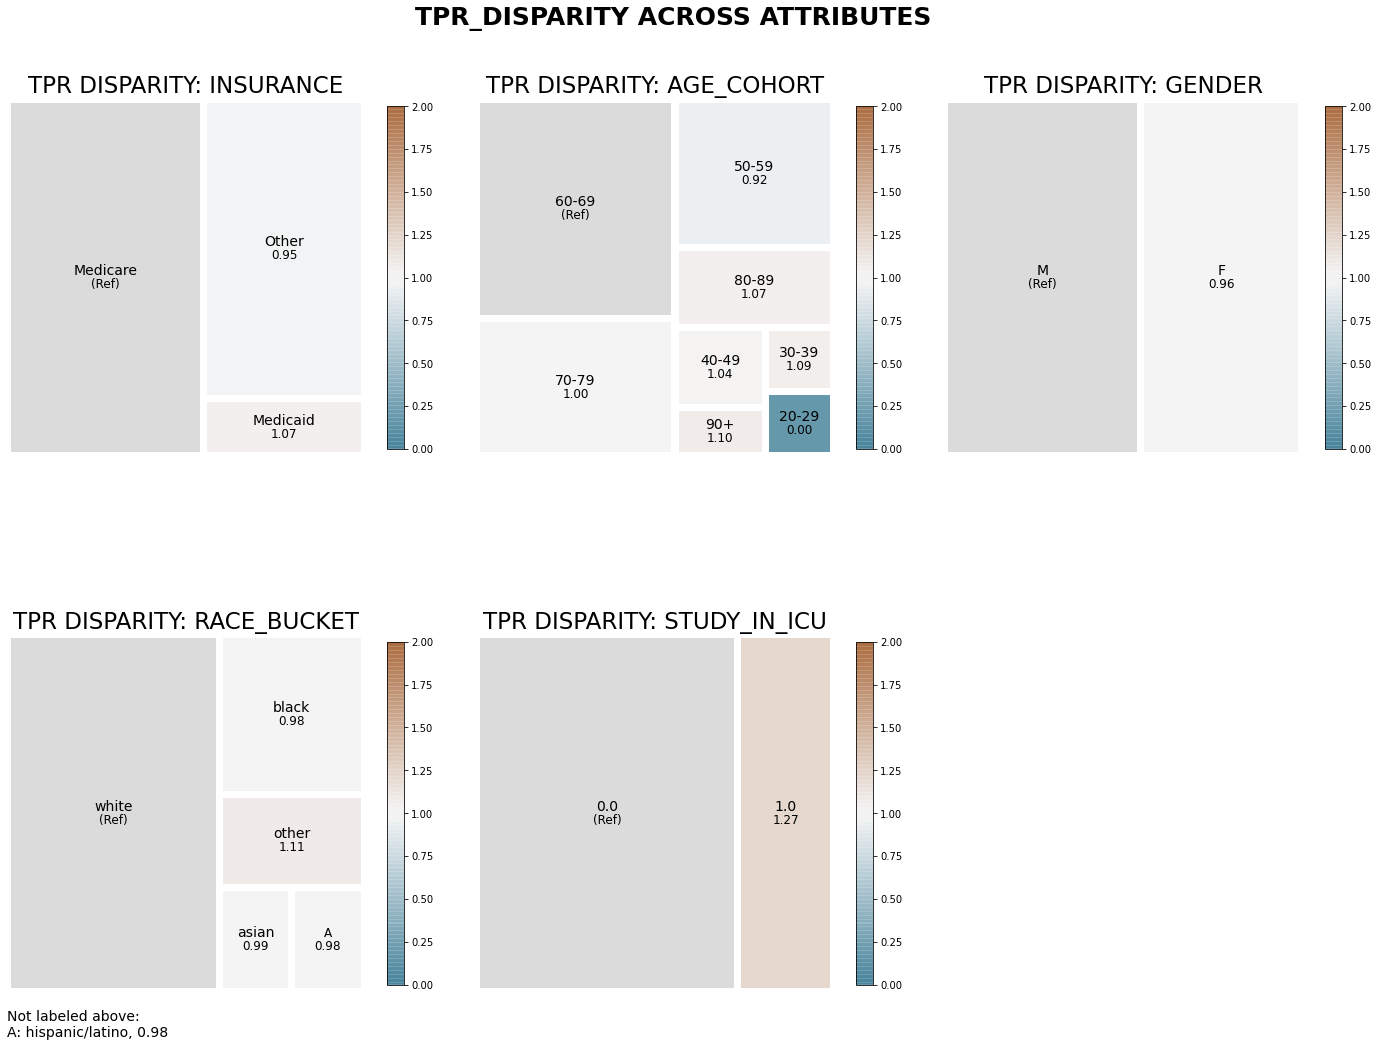

In [30]:
aqp = Plot()

for i, tpr_disparity in enumerate(label_tpr_disparity):
    print(labels[i])
    fig = aqp.plot_disparity_all(label_tpr_disparity[i][0], metrics=['tpr_disparity'], show_figure=False)
    fig.savefig((labels[i] + '_tpr_disparity.png'))
    print()